### Quasi optics - on-axis calculations of EXCLAIM optics
In this code we estimate analytically the on-axis calculations for the EXCLAIM optics, simulating the mirrors with lenses of equivalent focal length. We will later perform the Fresnel diffraction calculations using PoPPy code.

This block goes utilizes Gaussian optics calculations in Goldsmith (1998) -- see the summary here in the 'Gaussian Beam Optics' section: https://www.overleaf.com/read/gykryddxcnhh


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import constants as const
from scipy.special import i0, k0

In [2]:
import poppy
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
poppy.__version__

Populating the interactive namespace from numpy and matplotlib


'0.9.0'

Library of ABCD matrices for various quasioptical elements

In [3]:
def ABCD_thin_lens(f):
    return [[1., 0.],[-1./f.value,1.]]

def ABCD_two_thin_lenses_separated_by_focal_lengths(f_1,f_2):
    return [[-f_2/f_1,f_1+f_2],[0,-f_1/f_2]]

def ABCD_uniform_medium(d):
    return [[1,d.value],[0,1]]

Other various functions:

In [4]:
# confocal / Rayleigh distance
def z_c(w_0,ll):
    return np.pi*w_0**2/ll

# waist size as a function of z
def w_z(w_0,z,z_c):
    return w_0 * (1 + z**2/z_c**2)**.5

# ABCD matrix calculation of w_0_out, d_out compared to w_0_in, d_in
def w_0_d_out(w_0_in,d_in,z_c,ABCD):
    A = ABCD[0][0]
    B = ABCD[0][1]
    C = ABCD[1][0]
    D = ABCD[1][1]
    
    w_0_out = w_0_in/((C*d_in+D)**2 + C**2*z_c**2)**.5
    d_out = -((A*d_in+B)*(C*d_in+D) + A*C*z_c**2) / ((C*d_in+D)**2 + C**2*z_c**2)
    
    return w_0_out,d_out

# returns fraction of power lost and effective waist size for truncated 
# Gaussian with radius of truncation r_t
def gaussian_truncated_power(r_t,w):
    f = np.exp(-r_t^2 / w^2)
    w_eff = w*(1 - f**.5)
    
    return f,w_eff

EXCLAIM optics parameters (all in cm):

In [5]:
# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm

f_lens = 24 * u.cm

# waist at lenslet. From Negar's slides on the lenslet. Output at ~500GHz
# 420GHz: 1.618mm
# 470GHz: 1.616mm
# 480GHz: 1.680mm
# 520GHz: 1.715mm
# 540GHz: 1.708mm

w_0_lenslet = .17 * u.cm 

# CST simulation positions (y,z):
lens_top_position = [-84.67,-51.06] * u.cm
tertiary_position = [-84.67,-18] * u.cm
secondary_position = [0.,0.] * u.cm
primary_position = [-98.67,35.89] * u.cm

d_lenslet_lens = 24 * u.cm
d_lens_3 = ((lens_top_position[0]-tertiary_position[0])**2+(lens_top_position[1]-tertiary_position[1])**2)**.5
d_3_2 = ((secondary_position[0]-tertiary_position[0])**2+(secondary_position[1]-tertiary_position[1])**2)**.5
d_2_1 = ((secondary_position[0]-primary_position[0])**2+(secondary_position[1]-primary_position[1])**2)**.5

print("Distances:")
print("\tLenslet-lens: %.3f cm" %d_lenslet_lens.value)
print("\tLens-tertiary: %.3f cm" %d_lens_3.value)
print("\tTertiary-secondary: %.3f cm" %d_3_2.value)
print("\tSecondary-primary: %.3f cm" %d_2_1.value)



Distances:
	Lenslet-lens: 24.000 cm
	Lens-tertiary: 33.060 cm
	Tertiary-secondary: 86.562 cm
	Secondary-primary: 104.995 cm


Step 1: perfect Gaussian input, 15dB at 3cm

Input: 1.2mm waist at the position of the lenslet
Four different sections:
i - pre-lens. Calculates beam width at the lens
ii - post-lens. Calculates image waist size & position based on ray-tracing & quasi-optics
iii - post-tertiary. Calculates image waist size & position based on ray-tracing & quasi-optics
iv - post-secondary. Calculates image waist size & position based on ray-tracing & quasi-optics
v - post-primary. Calculates image waist size & position based on ray-tracing & quasi-optics

Notes/issues:
- sign with d_in vs d_out?? Quasi-optics & ray-tracing calculations seem to match up otherwise

In [6]:
# waist size, distance to focus of lens
ff = 500*u.GHz#500*u.GHz
ll = const.c/ff
#print(ll.to(u.um))

z_c_lenslet = z_c(w_0_lenslet,ll)
print("z_c for lenslet: %.3f cm" % z_c_lenslet.to(u.cm).value )

print("\n~~~~~~~~~~~ Pre-lens ~~~~~~~~~~~")
# calculates propagation through uniform material with distance cor

ABCD_lenslet = ABCD_uniform_medium(d_lenslet_lens)
#print(ABCD_lenslet)

# Gaussian optics with transfer matrices
w_0_pre_lens,d_out_pre_lens = w_0_d_out(w_0_lenslet.to(u.cm).value,
                        d_lenslet_lens.to(u.cm).value,
                        z_c_lenslet.to(u.cm).value,
                        ABCD_lenslet)

print("w_0 pre-lens: %.3f cm" %w_0_pre_lens)
print("distance to waist pre-lens: %.3f cm" %d_out_pre_lens)
print("w pre_lens: %.4f cm" % w_z(w_0_lenslet.value,d_lenslet_lens.to(u.cm).value,z_c_lenslet.to(u.cm).value))

print("\n~~~~~~~~~~~ Post-lens ~~~~~~~~~~~")
ABCD_lenslet_lens = ABCD_thin_lens(f_lens)
#print(ABCD_lenslet_lens)

# Ray-tracing:
lens_object_distance = d_lenslet_lens
lens_image_distance = 1./(1./f_lens - 1./lens_object_distance)
print("Waist/focus object distance, ray-tracing: %.3f cm" %lens_image_distance.to(u.cm).value)

# Gaussian optics with transfer matrices
"""
q_lens_in = (d_lenslet_lens.to(u.cm) + 1j*z_c_lenslet.to(u.cm)).value
q_lens_out = (ABCD_lenslet_lens[0][0]*q_lens_in + ABCD_lenslet_lens[0][1])/(ABCD_lenslet_lens[1][0]*q_lens_in + ABCD_lenslet_lens[1][1])

d_out_post_lens_0 = np.real(q_lens_out)
w_0_post_lens_0 = (-ll.to(u.cm).value/(np.pi*np.imag(1./q_lens_out)))**.5
"""

w_0_post_lens,d_out_post_lens = w_0_d_out(w_0_lenslet.to(u.cm).value,
                        d_lenslet_lens.to(u.cm).value,
                        z_c_lenslet.to(u.cm).value,
                        ABCD_lenslet_lens)

print("w_0 post-lens: %.3f cm" %w_0_post_lens)
print("distance to waist post-lens: %.3f cm" %d_out_post_lens)

print("\n~~~~~~~~~~~ Post-tertiary ~~~~~~~~~~~")
#z_c_lens = z_c(w_0_post_lens*u.cm,ll)
#print("z_c for lens: %.3f cm" % z_c_lens.to(u.cm).value )

# Ray-tracing:
tertiary_object_distance = d_lens_3 - lens_image_distance
tertiary_image_distance = 1./(1./f_3 - 1./tertiary_object_distance)
print("Waist/focus object distance, ray-tracing: %.3f cm" %tertiary_image_distance.to(u.cm).value)

# Gaussian optics with transfer matrices
ABCD_lenslet_tertiary = np.asarray(np.matmul(np.matmul(np.array(ABCD_thin_lens(f_3)),
                                            np.array(ABCD_uniform_medium(d_lens_3))),
                                            np.array(ABCD_lenslet_lens)))

#print(ABCD_lenslet_tertiary)

w_0_post_tertiary,d_out_post_tertiary = w_0_d_out(w_0_lenslet.to(u.cm).value,
                        d_lenslet_lens.to(u.cm).value,
                        z_c_lenslet.to(u.cm).value,
                        ABCD_lenslet_tertiary)

print("w_0 post-tertiary: %.3f cm" %w_0_post_tertiary)
print("distance to waist post-tertiary: %.3f cm" %d_out_post_tertiary)

print("\n~~~~~~~~~~~ Post-secondary ~~~~~~~~~~~")
#z_c_lens = z_c(w_0_post_lens*u.cm,ll)
#print("z_c for lens: %.3f cm" % z_c_lens.to(u.cm).value )

# Ray-tracing:
secondary_object_distance = d_3_2 - tertiary_image_distance
secondary_image_distance = 1./(1./f_2 - 1./secondary_object_distance)
print("Waist/focus object distance, ray-tracing: %.3f cm" %secondary_image_distance.to(u.cm).value)

# Gaussian optics with transfer matrices
ABCD_lenslet_secondary = np.asarray(np.matmul(np.matmul(np.array(ABCD_thin_lens(f_2)),
                                            np.array(ABCD_uniform_medium(d_3_2))),
                                            np.array(ABCD_lenslet_tertiary)))

#print(ABCD_lenslet_tertiary)

w_0_post_secondary,d_out_post_secondary = w_0_d_out(w_0_lenslet.to(u.cm).value,
                        d_lenslet_lens.to(u.cm).value,
                        z_c_lenslet.to(u.cm).value,
                        ABCD_lenslet_secondary)

print("w_0 post-secondary: %.3f cm" %w_0_post_secondary)
print("distance to waist post-secondary: %.3f cm" %d_out_post_secondary)

print("\n~~~~~~~~~~~ Post-primary ~~~~~~~~~~~")
#z_c_lens = z_c(w_0_post_lens*u.cm,ll)
#print("z_c for lens: %.3f cm" % z_c_lens.to(u.cm).value )

# Ray-tracing:
primary_object_distance = d_2_1 - secondary_image_distance
primary_image_distance = 1./(1./f_1 - 1./primary_object_distance)
print("Waist/focus object distance, ray-tracing: %.3f cm" %primary_image_distance.to(u.cm).value)

# Gaussian optics with transfer matrices
ABCD_lenslet_primary = np.asarray(np.matmul(np.matmul(np.array(ABCD_thin_lens(f_1)),
                                            np.array(ABCD_uniform_medium(d_2_1))),
                                            np.array(ABCD_lenslet_secondary)))

#print(ABCD_lenslet_tertiary)

w_0_post_primary,d_out_post_primary = w_0_d_out(w_0_lenslet.to(u.cm).value,
                        d_lenslet_lens.to(u.cm).value,
                        z_c_lenslet.to(u.cm).value,
                        ABCD_lenslet_primary)

print("w_0 post-primary: %.3f cm" %w_0_post_primary)
print("distance to waist post-primary: %.3f cm" %d_out_post_primary)


z_c for lenslet: 1.514 cm

~~~~~~~~~~~ Pre-lens ~~~~~~~~~~~
w_0 pre-lens: 0.170 cm
distance to waist pre-lens: -48.000 cm
w pre_lens: 2.6998 cm

~~~~~~~~~~~ Post-lens ~~~~~~~~~~~
Waist/focus object distance, ray-tracing: inf cm
w_0 post-lens: 2.694 cm
distance to waist post-lens: 24.000 cm

~~~~~~~~~~~ Post-tertiary ~~~~~~~~~~~
Waist/focus object distance, ray-tracing: 19.200 cm
w_0 post-tertiary: 0.136 cm
distance to waist post-tertiary: 19.174 cm

~~~~~~~~~~~ Post-secondary ~~~~~~~~~~~
Waist/focus object distance, ray-tracing: -67.744 cm
w_0 post-secondary: 0.137 cm
distance to waist post-secondary: -67.770 cm

~~~~~~~~~~~ Post-primary ~~~~~~~~~~~
Waist/focus object distance, ray-tracing: 1509.365 cm
w_0 post-primary: 1.191 cm
distance to waist post-primary: 1503.282 cm


/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


# Poppy calculations

In [7]:
plot_widths = False
width_array = [] # append for each step_dist for plot of width sizes
step_dist = 0.01 * u.cm

## Initialize objects for optical elements

# waist at lenslet, initialize Gaussian w/ FWHM=waist

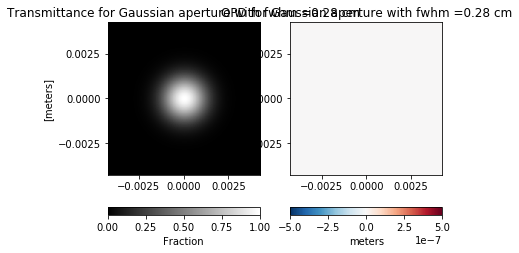

In [38]:
lenslet_aperture = poppy.GaussianAperture(w=w_0_lenslet)
lenslet_aperture.display(what='both');

In [9]:
lens_obj = poppy.QuadraticLens(f_lens)
tertiary_obj = poppy.QuadraticLens(f_3)
secondary_obj = poppy.QuadraticLens(f_2)
primary_obj = poppy.QuadraticLens(f_1)

After aperture, beam waist is at 0.0 m


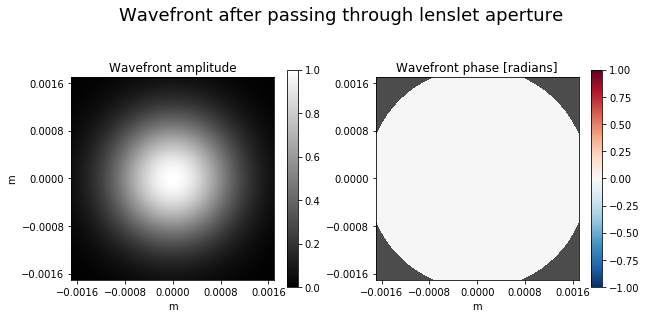

In [10]:
wf = poppy.FresnelWavefront(beam_radius=w_0_lenslet, wavelength=ll)
wf *= lenslet_aperture

print("After aperture, beam waist is at {}".format(wf.z_w0) )

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True);
plt.suptitle("Wavefront after passing through lenslet aperture", fontsize=18);

Before lens:
	Waist is 0.17 cm
	Waist position is 0.0 cm
	Beam width is 2.699764313287148 cm


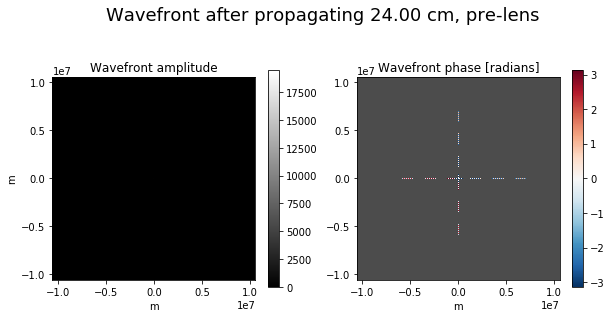

In [11]:
if plot_widths:
    for mm in range(int(round(d_lenslet_lens.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm).value)
else:
     wf.propagate_fresnel(d_lenslet_lens)
        
plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront after propagating %.2f cm, pre-lens" %d_lenslet_lens.value, fontsize=18);

print("Before lens:")
print("\tWaist is {}".format(wf.w_0.to(u.cm) ))
print("\tWaist position is {}".format(wf.z_w0.to(u.cm) ))
print("\tBeam width is {}".format(wf.spot_radius().to(u.cm)) )

/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


After lens:
	Waist is 2.6944066781573315 cm
	Waist position is 24.00000000000011 cm
	Beam width is 2.699764313287148 cm


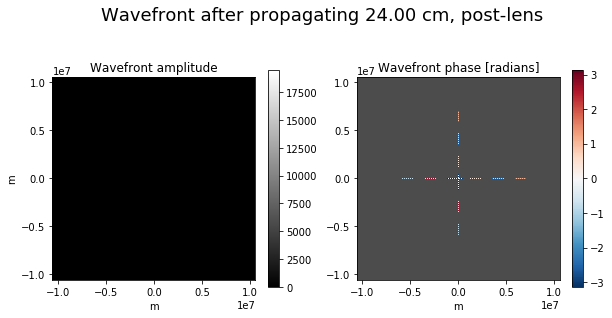

In [12]:
wf*=lens_obj

waist_post_lens = wf.z_w0-d_lenslet_lens

print("After lens:")
print("\tWaist is {}".format(wf.w_0.to(u.cm) ))
print("\tWaist position is {}".format(waist_post_lens.to(u.cm) ))
print("\tBeam width is {}".format(wf.spot_radius().to(u.cm)) )

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront after propagating %.2f cm, post-lens" %d_lenslet_lens.value, fontsize=18);

After tertiary:
	Waist is 0.13578877071270987 cm
	Waist position is 19.151263274306373 cm
	Beam width is 2.69517082536967 cm


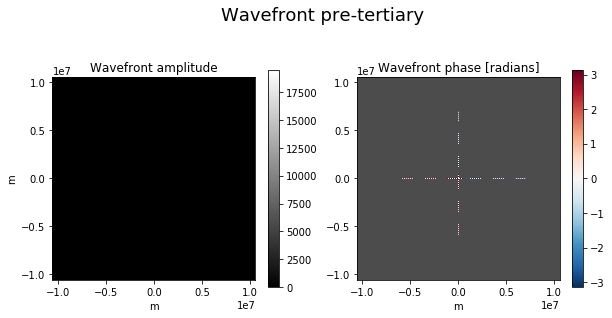

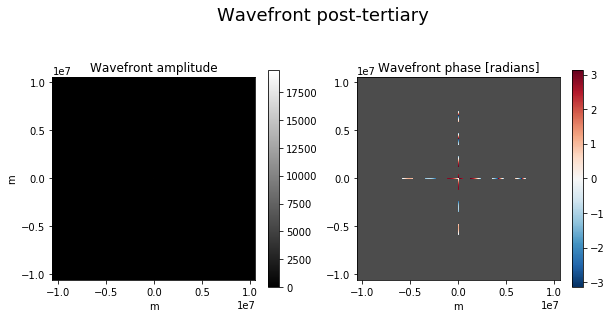

In [13]:
if plot_widths:
    for mm in range(int(round(d_lens_3.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm))
else:
    wf.propagate_fresnel(d_lens_3)

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront pre-tertiary", fontsize=18);

wf*=tertiary_obj
waist_post_tertiary = wf.z_w0-d_lens_3-d_lenslet_lens

print("After tertiary:")
print("\tWaist is {}".format(wf.w_0.to(u.cm) ))
print("\tWaist position is {}".format(waist_post_tertiary.to(u.cm) ))
print("\tBeam width is {}".format(wf.spot_radius().to(u.cm)) )


plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront post-tertiary", fontsize=18);

After secondary:
	Waist is 0.13655975995703176 cm
	Waist position is -67.79357475989717 cm
	Beam width is 9.475709124745325 cm


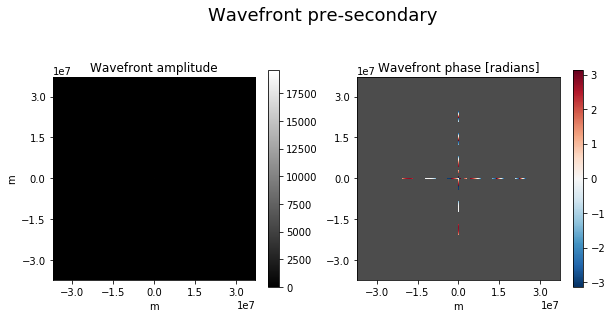

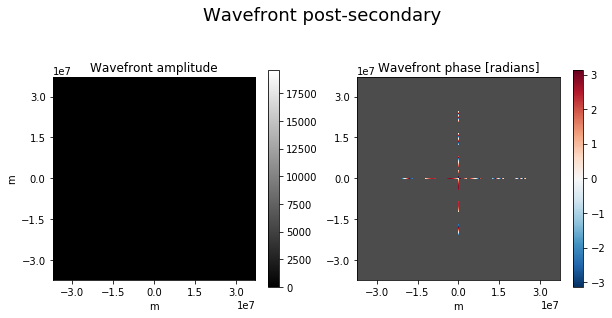

In [14]:
if plot_widths:
    for mm in range(int(round(d_3_2.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm))
else:
    wf.propagate_fresnel(d_3_2)

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront pre-secondary", fontsize=18);

wf*=secondary_obj

waist_post_secondary = wf.z_w0-d_3_2-d_lens_3-d_lenslet_lens

print("After secondary:")
print("\tWaist is {}".format(wf.w_0.to(u.cm) ))
print("\tWaist position is {}".format(waist_post_secondary.to(u.cm) ))
print("\tBeam width is {}".format(wf.spot_radius().to(u.cm)) )

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront post-secondary", fontsize=18);

After primary:
	Waist is 1.1881449167726097 cm
	Waist position is 1501.5551399804642 cm
	Beam width is 24.14899057364922 cm


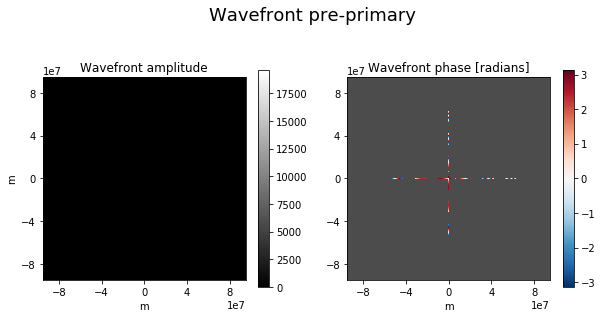

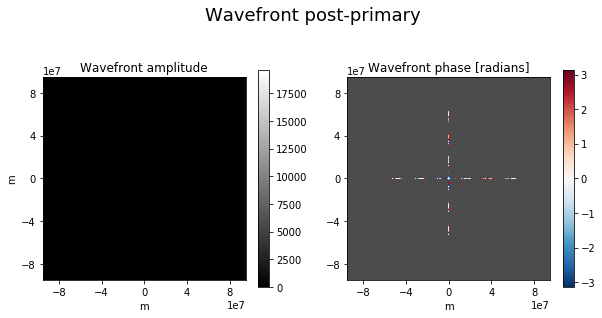

In [15]:
if plot_widths:
    for mm in range(int(round(d_2_1.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm))
else:
    wf.propagate_fresnel(d_2_1)

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront pre-primary", fontsize=18);

wf*=primary_obj

waist_post_primary = wf.z_w0-d_2_1-d_3_2-d_lens_3-d_lenslet_lens

print("After primary:")
print("\tWaist is {}".format(wf.w_0.to(u.cm) ))
print("\tWaist position is {}".format(waist_post_primary.to(u.cm) ))
print("\tBeam width is {}".format(wf.spot_radius().to(u.cm)) )

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront post-primary", fontsize=18);

## Summary of waist positions between ray-tracing, analytical quasioptical, and poppy calculations:

In [16]:
print("Post-lens:")
print("Ray-tracing: %.2f \t Analytical: %.2f \t poppy: %.2f " %(lens_image_distance.value,d_out_post_lens,waist_post_lens.to(u.cm).value))

print("Post-tertiary:")
print("Ray-tracing: %.2f \t Analytical: %.2f \t poppy: %.2f " %(tertiary_image_distance.value,d_out_post_tertiary,waist_post_tertiary.to(u.cm).value))

print("Post-secondary:")
print("Ray-tracing: %.2f \t Analytical: %.2f \t poppy: %.2f " %(secondary_image_distance.value,d_out_post_secondary,waist_post_secondary.to(u.cm).value))

print("Post-primary:")
print("Ray-tracing: %.2f \t Analytical: %.2f \t poppy: %.2f " %(primary_image_distance.value,d_out_post_primary,waist_post_primary.to(u.cm).value))


Post-lens:
Ray-tracing: inf 	 Analytical: 24.00 	 poppy: 24.00 
Post-tertiary:
Ray-tracing: 19.20 	 Analytical: 19.17 	 poppy: 19.15 
Post-secondary:
Ray-tracing: -67.74 	 Analytical: -67.77 	 poppy: -67.79 
Post-primary:
Ray-tracing: 1509.37 	 Analytical: 1503.28 	 poppy: 1501.56 


Distances:
	Lenslet-lens: 24.000 cm
	Lenslet-tertiary: 57.060 cm
	Lenslet-secondary: 143.622 cm
	Lenslet-primary: 248.617 cm


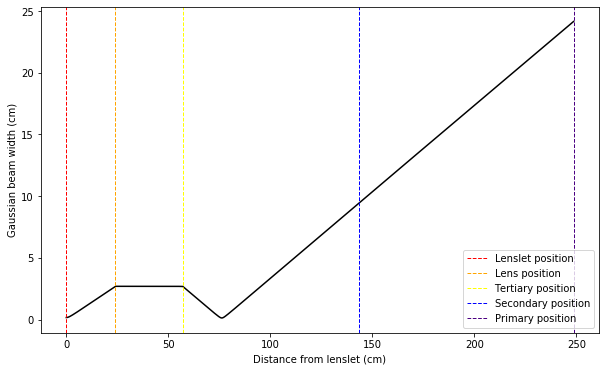

In [37]:
if not plot_widths:
    width_array = np.loadtxt('no_baffle_width_array.txt')
distance_array = np.linspace(0,len(width_array)/100,len(width_array))

d_lenslet_3 = d_lenslet_lens+d_lens_3
d_lenslet_2 = d_lenslet_3 + d_3_2
d_lenslet_1 = d_lenslet_2 + d_2_1

print("Distances:")
print("\tLenslet-lens: %.3f cm" %d_lenslet_lens.value)
print("\tLenslet-tertiary: %.3f cm" %d_lenslet_3.value)
print("\tLenslet-secondary: %.3f cm" %d_lenslet_2.value)
print("\tLenslet-primary: %.3f cm" %d_lenslet_1.value)



plt.figure(figsize=(10,6))
plt.plot(distance_array,width_array,color='black')
plt.xlabel('Distance from lenslet (cm)')
plt.ylabel('Gaussian beam width (cm)')
plt.axvline(x=0,linewidth=1, color='red',linestyle='--',label='Lenslet position')
plt.axvline(x=d_lenslet_lens.value,linewidth=1, color='orange',linestyle='--',label='Lens position')
plt.axvline(x=(d_lenslet_3).value,linewidth=1, color='yellow',linestyle='--',label='Tertiary position')
plt.axvline(x=(d_lenslet_2).value,linewidth=1, color='blue',linestyle='--',label='Secondary position')
plt.axvline(x=(d_lenslet_1).value,linewidth=1, color='indigo',linestyle='--',label='Primary position')
plt.legend()
plt.show()